# Univariate Bijections
## Background
[Normalizing Flows](https://flowtorch.ai/dev/bibliography#surveys) are a family of methods for constructing flexible distributions. As mentioned in [the introduction](https://flowtorch.ai/users), Normalizing Flows can be seen as a modern take on the [change of variables method for random distributions](https://en.wikipedia.org/wiki/Probability_density_function#Function_of_random_variables_and_change_of_variables_in_the_probability_density_function), and this is most apparent for univariate bijections. Thus, in this first section we restrict our attention to representing univariate distributions with bijections.

The basic idea is that a simple source of noise, for example a variable with a standard normal distribution, $X\sim\mathcal{N}(0,1)$, is passed through a bijective (i.e. invertible) function, $g(\cdot)$ to produce a more complex transformed variable $Y=g(X)$. For such a random variable, we typically want to perform two operations: sampling and scoring. Sampling $Y$ is trivial. First, we sample $X=x$, then calculate $y=g(x)$. Scoring $Y$, or rather, evaluating the log-density $\log(p_Y(y))$, is more involved. How does the density of $Y$ relate to the density of $X$? We can use the substitution rule of integral calculus to answer this. Suppose we want to evaluate the expectation of some function of $X$. Then,

$$
\begin{aligned}
\mathbb{E}_{p_X(\cdot)}\left[f(X)\right] &= \int_{\text{supp}(X)}f(x)p_X(x)dx\\
     &= \int_{\text{supp}(Y)}f(g^{-1}(y))p_X(g^{-1}(y))\left|\frac{dx}{dy}\right|dy \\
     &= \mathbb{E}_{p_Y(\cdot)}\left[f(g^{-1}(Y))\right],
\end{aligned}
$$

where $\text{supp}(X)$ denotes the support of $X$, which in this case is $(-\infty,\infty)$. Crucially, we used the fact that $g$ is bijective to apply the substitution rule in going from the first to the second line. Equating the last two lines we get,

$$
\begin{aligned}
     \log(p_Y(y)) &= \log(p_X(g^{-1}(y)))+\log\left(\left|\frac{dx}{dy}\right|\right)\\
     &= \log(p_X(g^{-1}(y)))-\log\left(\left|\frac{dy}{dx}\right|\right).
\end{aligned}
$$

Inituitively, this equation says that the density of $Y$ is equal to the density at the corresponding point in $X$ plus a term that corrects for the warp in volume around an infinitesimally small length around $Y$ caused by the transformation.

If $g$ is cleverly constructed (and we will see several examples shortly), we can produce distributions that are more complex than standard normal noise and yet have easy sampling and computationally tractable scoring. Moreover, we can compose such bijective transformations to produce even more complex distributions. By an inductive argument, if we have $L$ transforms $g_{(0)}, g_{(1)},\ldots,g_{(L-1)}$, then the log-density of the transformed variable $Y=(g_{(0)}\circ g_{(1)}\circ\cdots\circ g_{(L-1)})(X)$ is

$$
\begin{aligned}
     \log(p_Y(y)) &= \log\left(p_X\left(\left(g_{(L-1)}^{-1}\circ\cdots\circ g_{(0)}^{-1}\right)\left(y\right)\right)\right)+\sum^{L-1}_{l=0}\log\left(\left|\frac{dg^{-1}_{(l)}(y_{(l)})}{dy'}\right|\right),
\end{aligned}
$$

where we've defined $y_{(0)}=x$, $y_{(L-1)}=y$ for convenience of notation. In the following tutorial, we will see how to generalize this method to multivariate $X$.


## Fixed Univariate `Bijector`s
[FlowTorch](https://flowtorch.ai) contains classes for representing *fixed* univariate bijective transformations. These are particularly useful for restricting the range of transformed distributions, for example to lie on the unit hypercube. (In the following sections, we will explore how to represent learnable bijectors.)

Let us begin by showing how to represent and manipulate a simple transformed distribution,

$$
\begin{aligned}
 X &\sim \mathcal{N}(0,1)\\
 Y &= \text{exp}(X).
\end{aligned}
$$

You may have recognized that this is by definition, $Y\sim\text{LogNormal}(0,1)$.

We begin by importing the relevant libraries:

In [2]:
import torch
import flowtorch.bijectors as B
import flowtorch.distributions as D
import matplotlib.pyplot as plt
import seaborn as sns

A variety of bijective transformations live in the [`flowtorch.bijectors`](https://flowtorch.ai/api/flowtorch.bijectors) module, and the classes to define transformed distributions live in [`flowtorch.distributions`](https://flowtorch.ai/api/flowtorch.distributions). We first create the base distribution of $X$ and the class encapsulating the transform $\text{exp}(\cdot)$:

In [3]:
dist_x = torch.distributions.Independent(
  torch.distributions.Normal(torch.zeros(1), torch.ones(1)), 
  1
)
bijector = B.Exp()

The class [`B.Exp`](https://flowtorch.ai/api/flowtorch.bijectors.exp) derives from [`B.Fixed`](https://flowtorch.ai/api/flowtorch.bijectors.fixed) and defines the forward, inverse, and log-absolute-derivative operations for this transform,
$$
\begin{aligned}
     g(x) &= \text{exp(x)}\\
     g^{-1}(y) &= \log(y)\\
     \log\left(\left|\frac{dg}{dx}\right|\right) &= y.
\end{aligned}
$$

In general, a bijector class defines these three operations, from which it is sufficient to perform sampling and scoring. *We should think of a bijector as a plan to construct a normalizing flow rather than the normalizing flow itself* - it requires being instantiated with a concrete base distribution supplying the relevant shape information,

In [4]:
dist_y = D.Flow(dist_x, bijector)

This statement returns the object `dist_y` of type [`flowtorch.distributions.Flow`](https://flowtorch.ai/api/flowtorch.distributions.flow) representing an object that has an interface compatible with `torch.distributions.Distribution`. We are able to sample and score from `dist_y` object using its methods `.sample`, `.rsample`, and `.log_prob`.

Now, plotting samples from both the base and transformed distributions to verify that we that have produced the log-normal distribution:

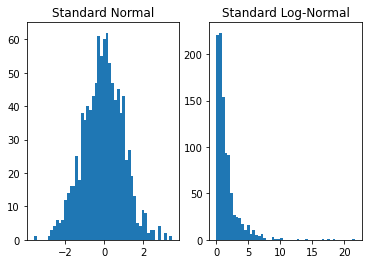

In [5]:
plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Standard Log-Normal')
plt.show()

Our example uses a single transform. However, we can compose transforms to produce more expressive distributions. For instance, if we apply an affine transformation we can produce the general log-normal distribution,

$$
\begin{aligned}
 X &\sim \mathcal{N}(0,1)\\
 Y &= \text{exp}(\mu+\sigma X).
\end{aligned}
$$

or rather, $Y\sim\text{LogNormal}(\mu,\sigma^2)$. In FlowTorch this is accomplished, e.g. for $\mu=3, \sigma=0.5$, as follows:

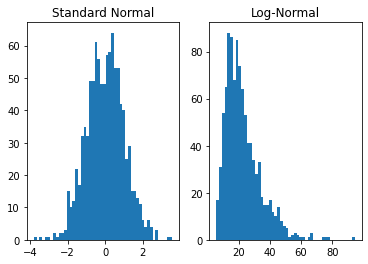

In [7]:
bijector = B.Compose([
     B.AffineFixed(loc=3, scale=0.5),
     B.Exp()])
dist_y = D.Flow(dist_x, bijector)

plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Log-Normal')
plt.show()

The class [`B.Compose`](https://flowtorch.ai/api/flowtorch.bijectors.compose) combines multiple [`B.Bijector`](https://flowtorch.ai/api/flowtorch.bijectors.bijector)'s with [function composition](https://en.wikipedia.org/wiki/Function_composition) to produce a single *plan* for a Normalizing Flow, which is then intiated in the regular way. For the forward operation, transformations are applied in the order of the list. In this case, first [`B.AffineFixed`](https://flowtorch.ai/api/flowtorch.bijectors.affinefixed) is applied to the base distribution and then [`B.Exp`](https://flowtorch.ai/api/flowtorch.bijectors.exp).

## Learnable Univariate `Bijector`s
Having introduced the interface for bijections and transformed distributions, we now show how to represent *learnable* transforms and use them for density estimation. Our dataset in this section and the next will comprise samples along two concentric circles. Examining the joint distribution:

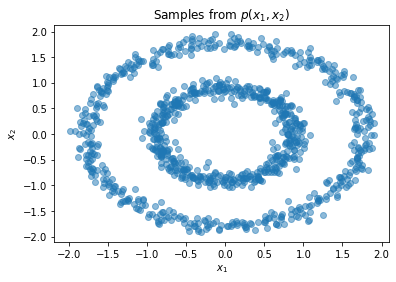

In [16]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = torch.Tensor(StandardScaler().fit_transform(X))

plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

And the marginals:

C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


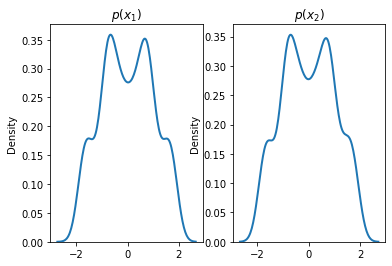

In [17]:
plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_2)$')
plt.show()

We will learn the marginals of the above distribution using a learnable transform, [`B.Spline`](https://flowtorch.ai/api/flowtorch.bijectors.spline), defined on a two-dimensional input:

In [18]:
dist_x = torch.distributions.Independent(
  torch.distributions.Normal(torch.zeros(2), torch.ones(2)), 
  1
)
bijector = B.Spline()
dist_y = D.Flow(dist_x, bijector)

[`B.Spline`](https://flowtorch.ai/api/flowtorch.bijectors.spline) passes each dimension of its input through a separate monotonically increasing function known as a spline. From a high-level, a spline is a complex parametrizable curve for which we can define specific points known as knots that it passes through and the derivatives at the knots. The knots and their derivatives are parameters that can be learnt, e.g., through stochastic gradient descent on a maximum likelihood objective, as we now demonstrate:

In [19]:
optimizer = torch.optim.Adam(dist_y.parameters(), lr=1e-2)
for step in range(1001):
    optimizer.zero_grad()
    loss = -dist_y.log_prob(X).mean()
    loss.backward()
    optimizer.step()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 2.862603187561035
step: 200, loss: -17.995046615600586
step: 400, loss: -29.19147491455078
step: 600, loss: -33.75411605834961
step: 800, loss: -34.60307693481445
step: 1000, loss: -34.999576568603516
step: 1200, loss: -35.23552322387695
step: 1400, loss: -35.39411163330078
step: 1600, loss: -35.508968353271484
step: 1800, loss: -35.5964241027832
step: 2000, loss: -35.66600799560547
step: 2200, loss: -35.73353958129883
step: 2400, loss: -35.813602447509766
step: 2600, loss: -35.85872268676758
step: 2800, loss: -35.89299774169922
step: 3000, loss: -35.92019271850586


Plotting samples drawn from the transformed distribution after learning:

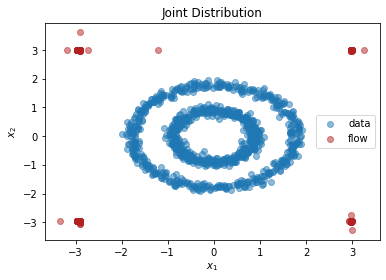

In [20]:
X_flow = dist_y.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot

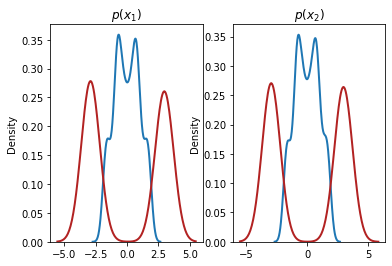

In [21]:
plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

As we can see, we have learnt close approximations to the marginal distributions, $p(x_1),p(x_2)$. *It would have been challenging to fit the irregularly shaped marginals with standard methods, for example, a mixture of normal distributions*. As expected, since there is a dependency between the two dimensions, we do not learn a good representation of the joint, $p(x_1,x_2)$. In the next section, we explain how to learn multivariate distributions whose dimensions are not independent.